In [1]:
import json
import pathlib
import re

import numpy as np
import pandas as pd
import sklearn.utils
import tqdm.notebook
import xgboost as xgb

from skrough.chaos_measures import gini_impurity
from skrough.structs.group_index import GroupIndex

random_state = sklearn.utils.check_random_state(1)

DATA_DIR = pathlib.Path("../../../toolbox/data_tmp/data")
TMP_DIR = pathlib.Path("../../../toolbox/data_tmp/tmp")
SEP = ","
ORIG_DISCRETIZED_SEP = ";"

DISCRETIZED_FILEPATH_IN = (
    DATA_DIR / "toolbox_tabular_data_annonymized_discretized_quantile.csv"
)
FILEPATH_IN = DATA_DIR / "toolbox_tabular_data_annonymized.csv"

DISCRETIZED_FILEPATH_IN_REORDERED = DATA_DIR / (
    DISCRETIZED_FILEPATH_IN.stem + "_with_reordered_cols.csv"
)
FILEPATH_IN_REORDERED = DATA_DIR / (FILEPATH_IN.stem + "_with_reordered_cols.csv")

FILEPATH_TEMPLATE_BIREDUCTS_LIST = (
    f"{TMP_DIR}/paper_ranks_3_/"
    "bireducts_list"
    "_dataset_{dataset}"
    "_n_bireducts_{n_bireducts}"
    "_n_of_probes_{n_of_probes}"
    "_allowed_randomness_{allowed_randomness}"
    "_candidate_n_attrs_{candidate_n_attrs}"
    "_max_n_attrs_{max_n_attrs}"
    ".csv"
)

# generate dataset with reordered cols

In [ ]:
# df = pd.read_csv(FILEPATH_IN, sep=SEP)
# df_dec = df.pop('target')
# df.drop('process_ids', axis=1, inplace=True)
# df2 = df.apply(lambda col: col.sample(n=len(df), replace=False, random_state=random_state).reset_index(drop=True), axis=0)
# df2 = df2.rename(lambda col_name: 'reordered_' + col_name, axis='columns')
# df = pd.concat([df, df2], axis=1)
# df.insert(df.shape[1], df_dec.name, df_dec)
# df.to_csv(FILEPATH_IN_REORDERED, sep=SEP, index=False)

In [ ]:
# df = pd.read_csv(DISCRETIZED_FILEPATH_IN, sep=ORIG_DISCRETIZED_SEP)
# df_dec = df.pop('target')
# df.drop('process_ids', axis=1, inplace=True)
# df2 = df.apply(lambda col: col.sample(n=len(df), replace=False, random_state=random_state).reset_index(drop=True), axis=0)
# df2 = df2.rename(lambda col_name: 'reordered_' + col_name, axis='columns')
# df = pd.concat([df, df2], axis=1)
# df.insert(df.shape[1], df_dec.name, df_dec)
# df.to_csv(DISCRETIZED_FILEPATH_IN_REORDERED, sep=SEP, index=False)

# utils

In [2]:
def __prepare_values(values):
    factorized_values, uniques = pd.factorize(values)
    uniques = len(uniques)
    return np.array([factorized_values, uniques], dtype=object)


def get_df(data_filepath=None, df=None, sep=SEP):
    if df is None:
        df = pd.read_csv(data_filepath, sep=sep)
    if "process_ids" in df.columns:
        df.drop("process_ids", axis=1, inplace=True)
    df_dec = df.pop("target").astype("category").cat.codes
    df_dec = 1 - df_dec
    return df, df_dec


def get_df_discretized(data_filepath=None, df=None, sep=SEP):
    if df is None:
        df = pd.read_csv(data_filepath, sep=sep)
    if "process_ids" in df.columns:
        df.drop("process_ids", axis=1, inplace=True)
    df = df.astype("category")
    df = df.apply(lambda x: x.cat.codes)
    df_dec = df.pop("target")
    df_dec = 1 - df_dec
    return df, df_dec


def prepare_df(df, df_dec):
    x = df
    y = df_dec
    x, y = sklearn.utils.check_X_y(x, y, multi_output=False)
    data = np.apply_along_axis(__prepare_values, 0, x)
    x = np.vstack(data[0]).T
    x_count_distinct = data[1]
    y, y_count_distinct = __prepare_values(y)
    return x, x_count_distinct, y, y_count_distinct

# compare attribures ranks

In [3]:
def compare3(scores, score_column, top_ks=None):
    scores = scores.sort_values([score_column], ascending=False)
    ranks = pd.DataFrame(
        {
            "column": scores["column"],
            "rank": np.arange(len(scores)) + 1,
            "is_reordered": scores["column"].str.contains("reordered_"),
        }
    )
    ranks["rank"] = ranks["rank"].groupby(scores[score_column]).transform("mean")
    ranks.reset_index(inplace=True, drop=True)
    result = {
        "avg_rank_normal_top_k_all": ranks[~ranks["is_reordered"]]["rank"].mean(),
        "avg_rank_reordered_top_k_all": ranks[ranks["is_reordered"]]["rank"].mean(),
    }
    if top_ks is not None:
        if isinstance(top_ks, int):
            top_ks = [top_ks]
        for top_k in top_ks:
            result[f"avg_rank_normal_top_k_{top_k}"] = (
                ranks[~ranks["is_reordered"]].iloc[:top_k]["rank"].mean()
            )
            result[f"avg_rank_reordered_top_k_{top_k}"] = (
                ranks[ranks["is_reordered"]].iloc[:top_k]["rank"].mean()
            )
    return result


def latex_compare_result(compare_result):
    result = []
    for k, v in compare_result.items():
        m = re.search(r"avg_rank_(normal|reordered)_top_k_(all|\d*)", k)
        result.append((m.group(1), m.group(2), v))
    df = pd.DataFrame(result, columns=("attr_type", "top_k", "avg_rank"))
    df = df.pivot(index="top_k", columns="attr_type", values="avg_rank")
    order = np.argsort([int(i) if i != "all" else 0 for i in df.index])
    df = df.iloc[order]
    return print(df.style.to_latex())

In [8]:
def compare_ranksum(scores, score_column):
    reordered_indicator = scores["column"].str.contains("reordered_")
    scores_normal = scores[~reordered_indicator][score_column]
    scores_reordered = scores[reordered_indicator][score_column]
    return scipy.stats.ranksums(scores_normal, scores_reordered)

# bireducts - compute bireducts list

In [8]:
def compute_bireducts(
    data_filepath,
    bireducts_list_filepath_template,
    n_bireducts,
    n_of_probes,
    allowed_randomness,
    candidate_n_attrs,
    max_n_attrs,
    sep=SEP,
):
    df, df_dec = get_df_discretized(data_filepath, sep=sep)

    daab = DynamicallyAdaptedApproximateBireduct(
        n_of_probes=n_of_probes,
        allowed_randomness=allowed_randomness,
        candidate_n_attrs=candidate_n_attrs,
        max_n_attrs=max_n_attrs,
    )
    daab.fit(df, df_dec, check_data_consistency=False)

    bireducts = []
    for i in tqdm.trange(n_bireducts):
        bireducts.append(attr.asdict(daab.get_bireduct()))

    with open(
        bireducts_list_filepath_template.format(
            dataset=pathlib.Path(data_filepath).stem,
            n_bireducts=n_bireducts,
            n_of_probes=n_of_probes,
            allowed_randomness=allowed_randomness,
            candidate_n_attrs=candidate_n_attrs,
            max_n_attrs=max_n_attrs,
        ),
        "w",
    ) as f:
        json.dump(bireducts, f)

In [ ]:
# compute_bireducts(DISCRETIZED_FILEPATH_IN_REORDERED, FILEPATH_TEMPLATE_BIREDUCTS_LIST,
#                   n_bireducts=1000, n_of_probes=100, allowed_randomness=0.05, candidate_n_attrs=100, max_n_attrs=None)
# compute_bireducts(DISCRETIZED_FILEPATH_IN_REORDERED, FILEPATH_TEMPLATE_BIREDUCTS_LIST,
#                   n_bireducts=1000, n_of_probes=100, allowed_randomness=0.05, candidate_n_attrs=100, max_n_attrs=3)

# bireducts

In [4]:
def get_chaos_score(xx, xx_count_distinct, yy, yy_count_distinct, attrs):
    group_index = GroupIndex.from_data(xx, xx_count_distinct, list(attrs))
    return group_index.get_chaos_score(yy, yy_count_distinct, gini_impurity)


def get_bireducts_scores(data_filepath, bireducts_list_filepath, sep=SEP):
    df_columns = pd.read_csv(data_filepath, sep=sep, nrows=0).columns[:-1]

    df, df_dec = get_df_discretized(data_filepath, sep=sep)
    xx, xx_count_distinct, yy, yy_count_distinct = prepare_df(df, df_dec)

    with open(bireducts_list_filepath) as f:
        bireducts = json.load(f)
    counts = np.zeros(xx.shape[1])
    global_gain = np.zeros(xx.shape[1])
    global_gain_cover = np.zeros(xx.shape[1])
    local_gain = np.zeros(xx.shape[1])
    local_gain_cover = np.zeros(xx.shape[1])
    for bireduct in tqdm.tqdm(bireducts):
        bireduct_objects = bireduct["objects"]
        bireduct_all_attrs = set(bireduct["attributes"])
        global_xxx = xx
        global_yyy = yy
        local_xxx = xx[bireduct_objects]
        local_yyy = yy[bireduct_objects]
        global_starting_chaos_score = get_chaos_score(
            global_xxx,
            xx_count_distinct,
            global_yyy,
            yy_count_distinct,
            bireduct_all_attrs,
        )
        local_starting_chaos_score = get_chaos_score(
            local_xxx,
            xx_count_distinct,
            local_yyy,
            yy_count_distinct,
            bireduct_all_attrs,
        )
        counts[bireduct["attributes"]] += 1
        for attr in bireduct["attributes"]:
            attrs_to_check = bireduct_all_attrs.difference([attr])
            global_current_chaos_score = get_chaos_score(
                global_xxx,
                xx_count_distinct,
                global_yyy,
                yy_count_distinct,
                attrs_to_check,
            )
            global_score_gain = global_current_chaos_score - global_starting_chaos_score
            global_gain[attr] += global_score_gain
            global_gain_cover[attr] += (
                global_score_gain * len(bireduct_objects) / xx.shape[0]
            )
            local_current_chaos_score = get_chaos_score(
                local_xxx,
                xx_count_distinct,
                local_yyy,
                yy_count_distinct,
                attrs_to_check,
            )
            local_score_gain = local_current_chaos_score - local_starting_chaos_score
            local_gain[attr] += local_score_gain
            local_gain_cover[attr] += (
                local_score_gain * len(bireduct_objects) / xx.shape[0]
            )
    avg_global_gain = np.divide(
        global_gain, counts, out=np.zeros_like(global_gain), where=counts > 0
    )
    avg_global_gain_cover = np.divide(
        global_gain_cover,
        counts,
        out=np.zeros_like(global_gain_cover),
        where=counts > 0,
    )
    avg_local_gain = np.divide(
        local_gain, counts, out=np.zeros_like(local_gain), where=counts > 0
    )
    avg_local_gain_cover = np.divide(
        local_gain_cover, counts, out=np.zeros_like(local_gain_cover), where=counts > 0
    )
    result = pd.DataFrame(
        {
            "column": df_columns,
            "count": counts,
            "global_gain": global_gain,
            "global_gain_cover": global_gain_cover,
            "avg_global_gain": avg_global_gain,
            "avg_global_gain_cover": avg_global_gain_cover,
            "local_gain": local_gain,
            "local_gain_cover": local_gain_cover,
            "avg_local_gain": avg_local_gain,
            "avg_local_gain_cover": avg_local_gain_cover,
        }
    )
    del bireducts
    return result

In [5]:
bireducts_list_filepath = FILEPATH_TEMPLATE_BIREDUCTS_LIST.format(
    dataset=pathlib.Path(DISCRETIZED_FILEPATH_IN_REORDERED).stem,
    n_bireducts=1000,
    n_of_probes=100,
    allowed_randomness=0.05,
    candidate_n_attrs=100,
    max_n_attrs=None,
)
bireducts_scores = get_bireducts_scores(
    DISCRETIZED_FILEPATH_IN_REORDERED, bireducts_list_filepath, sep=SEP
)

100%|██████████| 1000/1000 [01:04<00:00, 15.55it/s]


In [5]:
bireducts_list_filepath = FILEPATH_TEMPLATE_BIREDUCTS_LIST.format(
    dataset=pathlib.Path(DISCRETIZED_FILEPATH_IN_REORDERED).stem,
    n_bireducts=1000,
    n_of_probes=100,
    allowed_randomness=0.05,
    candidate_n_attrs=100,
    max_n_attrs=3,
)
bireducts_scores_3 = get_bireducts_scores(
    DISCRETIZED_FILEPATH_IN_REORDERED, bireducts_list_filepath, sep=SEP
)

100%|██████████| 1000/1000 [00:59<00:00, 16.77it/s]


In [39]:
bireducts_scores_3["global_gain"].sum()

2.548986145454799

In [16]:
importance = "global_gain"
scores = bireducts_scores_3
compare3(scores, importance, [10, 20, 30, 50, 100])
latex_compare_result(compare3(scores, importance, [10, 20, 30, 50, 100]))

\begin{tabular}{lrr}
attr_type & normal & reordered \\
top_k &  &  \\
all & 706.939119 & 838.060881 \\
10 & 5.500000 & 766.500000 \\
20 & 10.500000 & 802.750000 \\
30 & 15.500000 & 814.833333 \\
50 & 25.500000 & 824.500000 \\
100 & 50.500000 & 831.750000 \\
\end{tabular}



In [19]:
importance = "total_gain"
scores = xgboost_scores_2
compare3(scores, importance, [10, 20, 30, 50, 100])
latex_compare_result(compare3(scores, importance, [10, 20, 30, 50, 100]))

\begin{tabular}{lrr}
attr_type & normal & reordered \\
top_k &  &  \\
all & 763.000000 & 782.000000 \\
10 & 5.500000 & 782.000000 \\
20 & 48.600000 & 782.000000 \\
30 & 293.066667 & 782.000000 \\
50 & 488.640000 & 782.000000 \\
100 & 635.320000 & 782.000000 \\
\end{tabular}



In [24]:
compare3(bireducts_scores, "global_gain", [10, 20, 30, 50, 100])
latex_compare_result(compare3(bireducts_scores, "global_gain", [10, 20, 30, 50, 100]))

\begin{tabular}{lrr}
attr_type & normal & reordered \\
top_k &  &  \\
all & 714.956606 & 830.043394 \\
10 & 5.500000 & 67.100000 \\
20 & 10.500000 & 81.650000 \\
30 & 15.500000 & 94.600000 \\
50 & 25.920000 & 124.880000 \\
100 & 56.960000 & 470.815000 \\
\end{tabular}



In [11]:
compare3(bireducts_scores_3, "global_gain", [10, 20, 30, 50, 100])
latex_compare_result(compare3(bireducts_scores_3, "global_gain", [10, 20, 30, 50, 100]))

\begin{tabular}{lrr}
attr_type & normal & reordered \\
top_k &  &  \\
all & 706.939119 & 838.060881 \\
10 & 5.500000 & 766.500000 \\
20 & 10.500000 & 802.750000 \\
30 & 15.500000 & 814.833333 \\
50 & 25.500000 & 824.500000 \\
100 & 50.500000 & 831.750000 \\
\end{tabular}



In [13]:
compare3(xgboost_scores_3, "total_gain", [10, 20, 30, 50, 100])
latex_compare_result(compare3(xgboost_scores_2, "total_gain", [10, 20, 30, 50, 100]))

\begin{tabular}{lrr}
attr_type & normal & reordered \\
top_k &  &  \\
all & 763.000000 & 782.000000 \\
10 & 5.500000 & 782.000000 \\
20 & 48.600000 & 782.000000 \\
30 & 293.066667 & 782.000000 \\
50 & 488.640000 & 782.000000 \\
100 & 635.320000 & 782.000000 \\
\end{tabular}



In [ ]:
compare3(xgboost_scores_3, "total_gain", [10, 20, 30, 50, 100])
latex_compare_result(compare3(xgboost_scores_3, "total_gain", [10, 20, 30, 50, 100]))

In [ ]:
compare3(xgboost_scores_5, "total_gain", [10, 20, 30, 50, 100])
latex_compare_result(compare3(xgboost_scores_5, "total_gain", [10, 20, 30, 50, 100]))

In [ ]:
compare3(
    correlation_scores,
    "spearman_correlation",
    [
        10,
        20,
        30,
        50,
        100,
    ],
)
latex_compare_result(
    compare3(
        correlation_scores,
        "spearman_correlation",
        [
            10,
            20,
            30,
            50,
            100,
        ],
    )
)

In [ ]:
compare_ranksum(bireducts_scores, "global_gain")

In [ ]:
compare_ranksum(bireducts_scores_3, "global_gain")

In [ ]:
compare_ranksum(xgboost_scores_2, "total_gain")

In [ ]:
compare_ranksum(xgboost_scores_3, "total_gain")

In [ ]:
compare_ranksum(xgboost_scores_5, "total_gain")

In [ ]:
compare_ranksum(correlation_scores, "spearman_correlation")

# xgboost

In [6]:
def get_xgboost_scores(data_filepath, params, sep=SEP):
    df, df_dec = get_df(data_filepath, sep=sep)
    num_boost_round = params.pop("num_boost_round")
    dtrain = xgb.DMatrix(df, label=df_dec)
    cl = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    result = pd.DataFrame({"column": df.columns})
    result.set_index("column", drop=False, inplace=True)
    for importance_type in ("weight", "gain", "cover", "total_gain", "total_cover"):
        result[importance_type] = 0
        score = cl.get_score(importance_type=importance_type)
        result.loc[score.keys(), importance_type] = list(score.values())
    result.reset_index(drop=True, inplace=True)
    return result

In [7]:
params = {
    "num_boost_round": 1000,
    "learning_rate": 0.001,
    "max_depth": 2,
    "base_score": 0.0696,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
}
xgboost_scores_2 = get_xgboost_scores(FILEPATH_IN_REORDERED, params, sep=SEP)

In [8]:
params = {
    "num_boost_round": 1000,
    "learning_rate": 0.001,
    "max_depth": 3,
    "base_score": 0.0696,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
}
xgboost_scores_3 = get_xgboost_scores(FILEPATH_IN_REORDERED, params, sep=SEP)

In [47]:
params = {
    "num_boost_round": 1000,
    "learning_rate": 0.001,
    "max_depth": 5,
    "base_score": 0.0696,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
}
xgboost_scores_5 = get_xgboost_scores(FILEPATH_IN_REORDERED, params, sep=SEP)

In [17]:
compare3(xgboost_scores_2, "weight", [10, 20, 30, 100])

{'avg_rank_normal_top_k_all': 763.0,
 'avg_rank_reordered_top_k_all': 782.0,
 'avg_rank_normal_top_k_10': 5.5,
 'avg_rank_reordered_top_k_10': 782.0,
 'avg_rank_normal_top_k_20': 48.6,
 'avg_rank_reordered_top_k_20': 782.0,
 'avg_rank_normal_top_k_30': 293.06666666666666,
 'avg_rank_reordered_top_k_30': 782.0,
 'avg_rank_normal_top_k_100': 635.32,
 'avg_rank_reordered_top_k_100': 782.0}

In [18]:
compare3(xgboost_scores_3, "weight", [10, 20, 30, 100])

{'avg_rank_normal_top_k_all': 760.8788860103627,
 'avg_rank_reordered_top_k_all': 784.1211139896373,
 'avg_rank_normal_top_k_10': 5.5,
 'avg_rank_reordered_top_k_10': 26.9,
 'avg_rank_normal_top_k_20': 11.8,
 'avg_rank_reordered_top_k_20': 262.275,
 'avg_rank_normal_top_k_30': 18.483333333333334,
 'avg_rank_reordered_top_k_30': 440.85,
 'avg_rank_normal_top_k_100': 511.425,
 'avg_rank_reordered_top_k_100': 690.855}

In [19]:
compare3(xgboost_scores_5, "weight", [10, 20, 30, 100])

{'avg_rank_normal_top_k_all': 779.6968911917098,
 'avg_rank_reordered_top_k_all': 765.3031088082902,
 'avg_rank_normal_top_k_10': 6.9,
 'avg_rank_reordered_top_k_10': 17.45,
 'avg_rank_normal_top_k_20': 14.525,
 'avg_rank_reordered_top_k_20': 33.525,
 'avg_rank_normal_top_k_30': 21.783333333333335,
 'avg_rank_reordered_top_k_30': 46.083333333333336,
 'avg_rank_normal_top_k_100': 88.44,
 'avg_rank_reordered_top_k_100': 112.75}

In [20]:
compare_ranksum(xgboost_scores_2, "weight")

RanksumsResult(statistic=0.8372400335545404, pvalue=0.402457658777992)

In [21]:
compare_ranksum(xgboost_scores_3, "weight")

RanksumsResult(statistic=1.0241749333289554, pvalue=0.3057526562120514)

In [22]:
compare_ranksum(xgboost_scores_5, "weight")

RanksumsResult(statistic=-0.634265833982687, pvalue=0.5259073497396312)

# correlation

In [23]:
def get_correlation_scores(data_filepath, sep=SEP):
    df, df_dec = get_df(data_filepath, sep=sep)
    result = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for column in tqdm.tqdm(df.columns):
            result.append([column] + list(scipy.stats.spearmanr(df[column], df_dec)))
    result = pd.DataFrame(result, columns=("column", "spearman_correlation", "pvalue"))
    idx = result["spearman_correlation"].isna()
    result.loc[idx, "spearman_correlation"] = 0
    result.loc[idx, "pvalue"] = 1
    result["spearman_correlation"] = result["spearman_correlation"].abs()
    result["pvalue_score"] = 1 / (result["pvalue"] + 10 ** (-20))
    return result

In [24]:
correlation_scores = get_correlation_scores(FILEPATH_IN_REORDERED, sep=SEP)

100%|██████████| 1544/1544 [00:04<00:00, 333.72it/s]


In [25]:
compare3(correlation_scores, "pvalue_score", top_ks=[10, 20, 30, 50, 100, 200, 500])

{'avg_rank_normal_top_k_all': 636.6567357512953,
 'avg_rank_reordered_top_k_all': 908.3432642487047,
 'avg_rank_normal_top_k_10': 5.5,
 'avg_rank_reordered_top_k_10': 171.15,
 'avg_rank_normal_top_k_20': 10.5,
 'avg_rank_reordered_top_k_20': 197.65,
 'avg_rank_normal_top_k_30': 15.5,
 'avg_rank_reordered_top_k_30': 213.61666666666667,
 'avg_rank_normal_top_k_50': 25.52,
 'avg_rank_reordered_top_k_50': 244.03,
 'avg_rank_normal_top_k_100': 50.5,
 'avg_rank_reordered_top_k_100': 310.53,
 'avg_rank_normal_top_k_200': 102.2175,
 'avg_rank_reordered_top_k_200': 413.1775,
 'avg_rank_normal_top_k_500': 343.678,
 'avg_rank_reordered_top_k_500': 674.126}

In [26]:
compare3(
    correlation_scores, "spearman_correlation", top_ks=[10, 20, 30, 50, 100, 200, 500]
)

{'avg_rank_normal_top_k_all': 636.6567357512953,
 'avg_rank_reordered_top_k_all': 908.3432642487047,
 'avg_rank_normal_top_k_10': 5.5,
 'avg_rank_reordered_top_k_10': 171.15,
 'avg_rank_normal_top_k_20': 10.5,
 'avg_rank_reordered_top_k_20': 197.65,
 'avg_rank_normal_top_k_30': 15.5,
 'avg_rank_reordered_top_k_30': 213.61666666666667,
 'avg_rank_normal_top_k_50': 25.52,
 'avg_rank_reordered_top_k_50': 244.03,
 'avg_rank_normal_top_k_100': 50.5,
 'avg_rank_reordered_top_k_100': 310.53,
 'avg_rank_normal_top_k_200': 102.2175,
 'avg_rank_reordered_top_k_200': 413.1775,
 'avg_rank_normal_top_k_500': 343.678,
 'avg_rank_reordered_top_k_500': 674.126}

In [27]:
compare_ranksum(correlation_scores, "spearman_correlation")

RanksumsResult(statistic=11.971938854499346, pvalue=4.9849926754411247e-33)

In [28]:
correlation_scores

,column,spearman_correlation,pvalue,pvalue_score
0,feature_1_g1,0.020183,0.004309,232.080045
1,feature_3_g1,0.005055,0.474650,2.106817
2,feature_4_g1,0.022783,0.001271,786.839264
3,feature_8_g1,0.009315,0.187724,5.326972
4,feature_9_g1,0.011259,0.111303,8.984506
...,...,...,...,...
1539,reordered_feature_783_g2,0.001955,0.782197,1.278450
1540,reordered_feature_784_g2,0.011122,0.115735,8.640443
1541,reordered_feature_785_g2,0.003158,0.655126,1.526424
1542,reordered_feature_786_g2,0.001245,0.860281,1.162411


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    plot_precision_recall_curve,
    plot_roc_curve,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

In [3]:
RocCurveDisplay.from_predictions

<bound method RocCurveDisplay.from_predictions of <class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>>

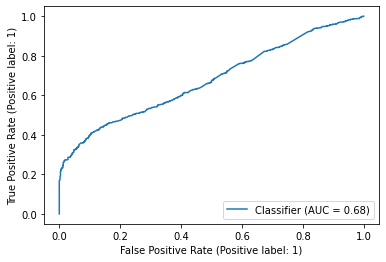

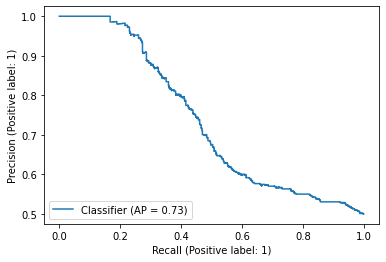

In [46]:
y_true = correlation_scores["column"].str.startswith("reordered_")
y_pred = correlation_scores["spearman_correlation"]
RocCurveDisplay.from_predictions(1 - y_true, y_pred)
PrecisionRecallDisplay.from_predictions(1 - y_true, y_pred)

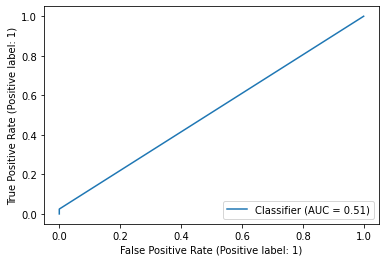

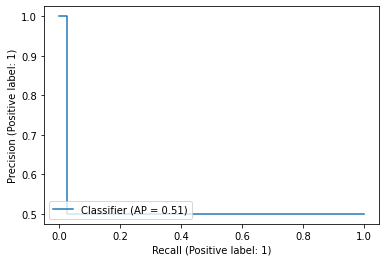

In [47]:
y_true = xgboost_scores_2["column"].str.startswith("reordered_")
y_pred = xgboost_scores_2["weight"]
RocCurveDisplay.from_predictions(1 - y_true, y_pred)
PrecisionRecallDisplay.from_predictions(1 - y_true, y_pred)

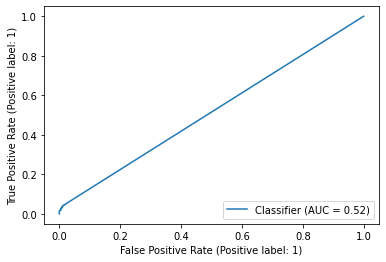

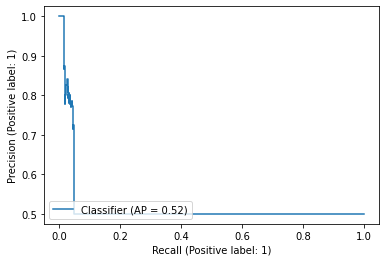

In [48]:
y_true = xgboost_scores_3["column"].str.startswith("reordered_")
y_pred = xgboost_scores_3["weight"]
RocCurveDisplay.from_predictions(1 - y_true, y_pred)
PrecisionRecallDisplay.from_predictions(1 - y_true, y_pred)

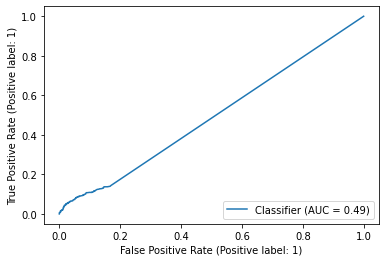

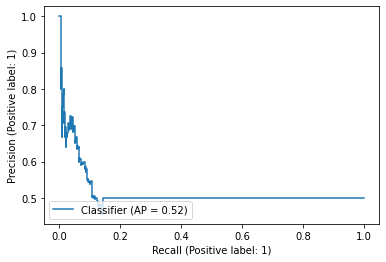

In [52]:
y_true = xgboost_scores_5["column"].str.startswith("reordered_")
y_pred = xgboost_scores_5["weight"]
RocCurveDisplay.from_predictions(1 - y_true, y_pred)
PrecisionRecallDisplay.from_predictions(1 - y_true, y_pred)

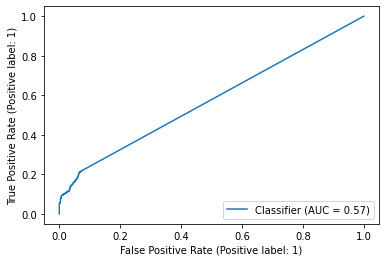

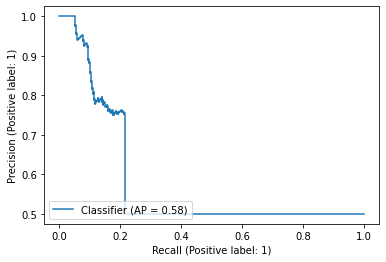

In [53]:
y_true = bireducts_scores["column"].str.startswith("reordered_")
y_pred = bireducts_scores["global_gain"]
RocCurveDisplay.from_predictions(1 - y_true, y_pred)
PrecisionRecallDisplay.from_predictions(1 - y_true, y_pred)

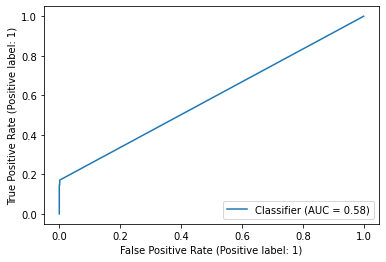

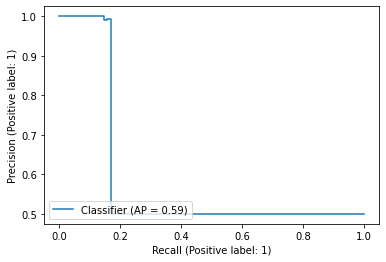

In [50]:
y_true = bireducts_scores_3["column"].str.startswith("reordered_")
y_pred = bireducts_scores_3["global_gain"]
RocCurveDisplay.from_predictions(1 - y_true, y_pred)
PrecisionRecallDisplay.from_predictions(1 - y_true, y_pred)